In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
import jax.random as random
rng = random.PRNGKey(2022)
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt

from mat_models import MR, mn_sigma_vmap as mn_sigma
from utils_node import init_params, init_params_aniso, NODE_model, NODE_model_aniso, NODE
from utils import train_jp, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, merge_weights_aniso
from utils_diffusion import *

In [2]:
def reverse_sde3(initial, forward_drift, dispersion, score, noises, ts=train_ts): # Pass in both the initial noise and the "infused" noise from outside
    def f(carry, params):
        t = params[0]
        dt = params[1]
        noise = params[2:]
        x = carry
        disp = dispersion(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = -forward_drift(x, 1-t) + disp**2 * score(x, 1-t)
        x = x + dt * drift + jnp.sqrt(dt)*disp*noise
        return x, ()
    
    dts = ts[1:] - ts[:-1]
    params = jnp.hstack([train_ts[:-1][:,None], dts[:,None], noises])
    x, _ = scan(f, initial, params)
    return x


n_neurons = 5
with open('params/mice_std_x_width_' + str(n_neurons) + '.npy', 'rb') as f:
    std_x = pickle.load(f)
with open('params/mice_mu_x_width_' + str(n_neurons) + '.npy', 'rb') as f:
    mu_x = pickle.load(f)
with open('params/mice_diffusion_params_width_' + str(n_neurons) + '.npy', 'rb') as f:
    params_diff = pickle.load(f)
with open('params/mice_node_m_width_'+str(n_neurons)+'.npy', 'rb') as f:
    params_all = pickle.load(f)
with open('params/mice_node_s_width_'+str(n_neurons)+'.npy', 'rb') as f:
    Sample_params = pickle.load(f)
validation_params = Sample_params[-1]
validation_params, unravel_params = ravel_pytree(validation_params)
validation_params = (validation_params-mu_x)/std_x

### Left side of the figure

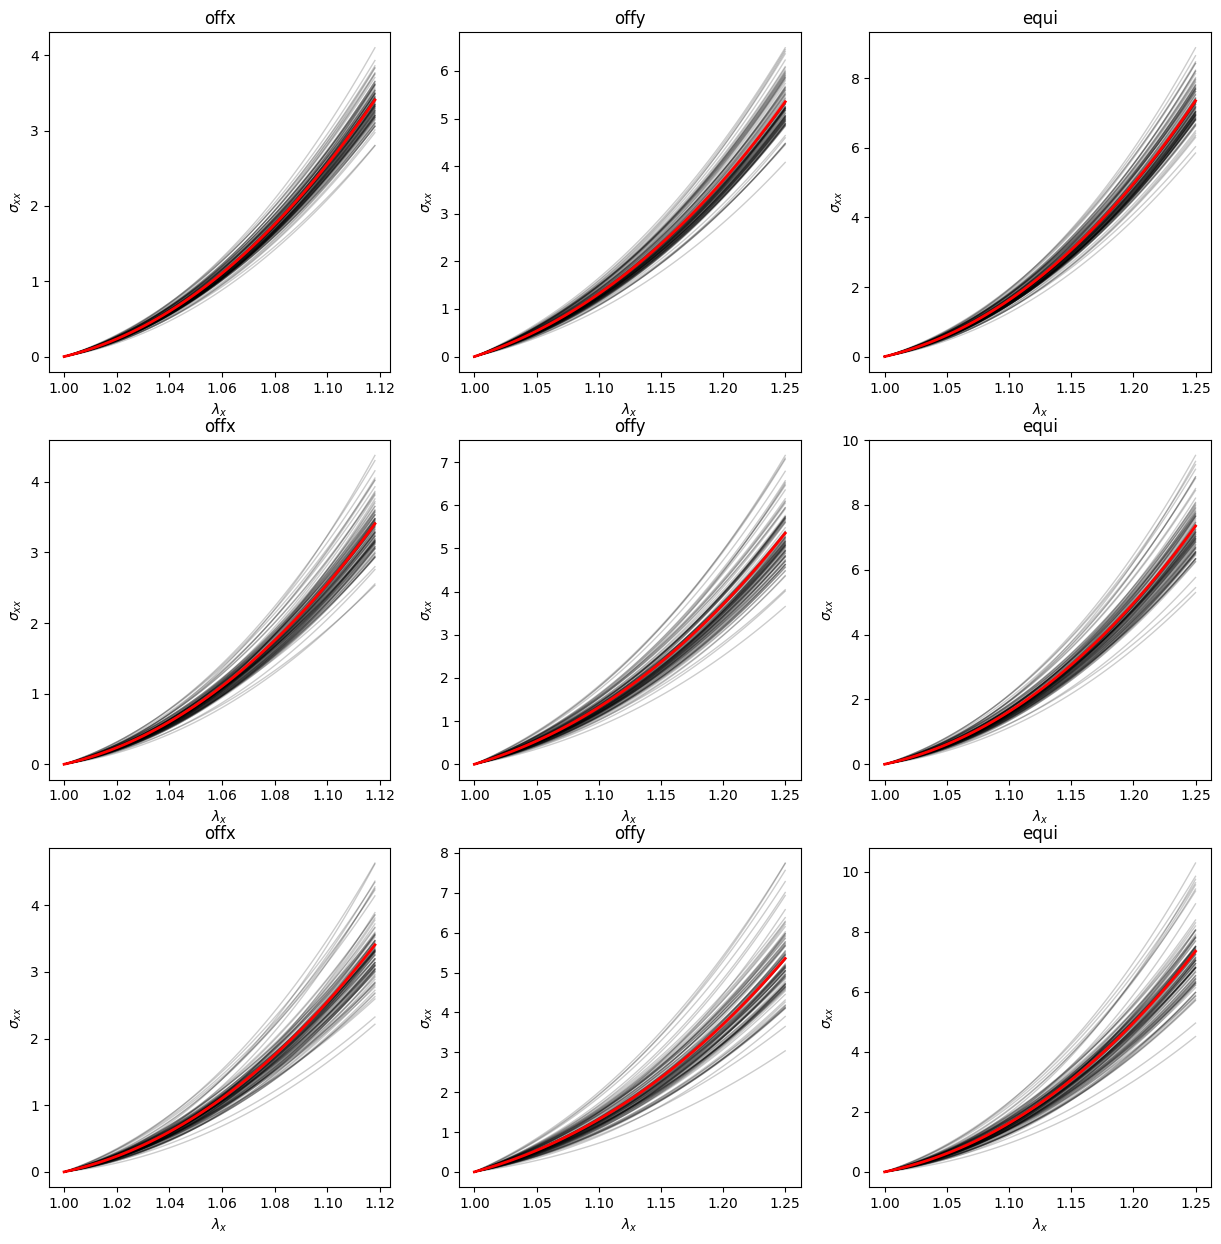

In [12]:
score_model = ApproximateScore()
trained_score = lambda x, t: score_model.apply(params_diff, x, t)
mod_score = lambda x, t, sgm_msr: trained_score(x,t) - (x-validation_params)/sgm_msr**2
n_params = 31

fig, axes = plt.subplots(3,3,figsize=(15,15))
lmbmax = 1.25
for sgmmsr, ax, panel in zip([0.04, 0.06, 0.08], axes, ['a', 'd', 'g']):
    mod_score_2 = lambda x, t: mod_score(x,t,sgmmsr) 
    samples = reverse_sde(rng, len(validation_params), 100, drift, dispersion, mod_score_2)
    ax[0].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$', title='offx')
    ax[1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$', title='offy')
    ax[2].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$', title='equi')

    lmby_offx = np.linspace(1,lmbmax) 
    lmbx_offx = np.sqrt(lmby_offx)
    lmbx_offy = np.linspace(1,lmbmax) 
    lmby_offy = np.sqrt(lmbx_offy)
    lmbx_equi = np.linspace(1,lmbmax)
    lmby_equi = lmbx_equi

    data_offx = [lmbx_offx]
    data_offy = [lmbx_offy]
    data_equi = [lmbx_equi]
    header = 'x'
    for i, l in enumerate(samples):
        l_unscaled = l*std_x+mu_x 
        sample_params = unravel_params(l_unscaled)
        params = merge_weights_aniso(params_all, sample_params)
        params[1] = 0.0 # Set theta = 0 because that is the case in FEM
        mymodel = NODE_model_aniso(params)
        sigx,sigy = eval_Cauchy_aniso_vmap(lmbx_offx,lmby_offx, mymodel) # Offx
        ax[0].plot(lmbx_offx, sigx*1000, color='k',linewidth=1,alpha=0.2)
        data_offx.append(sigx*1000)

        sigx,sigy = eval_Cauchy_aniso_vmap(lmbx_offy,lmby_offy, mymodel) # Offy
        ax[1].plot(lmbx_offy, sigx*1000, color='k',linewidth=1,alpha=0.2)
        data_offy.append(sigx*1000)

        sigx,sigy = eval_Cauchy_aniso_vmap(lmbx_equi,lmby_equi, mymodel) # Equibi
        ax[2].plot(lmbx_equi, sigx*1000, color='k',linewidth=1,alpha=0.2)
        data_equi.append(sigx*1000)
        header+=' y' + str(i)


    l_unscaled = validation_params*std_x+mu_x
    sample_params = unravel_params(l_unscaled)
    params = merge_weights_aniso(params_all, sample_params)
    params[1] = 0.0
    mymodel = NODE_model_aniso(params)
    sigx,sigy = eval_Cauchy_aniso_vmap(lmbx_offx,lmby_offx, mymodel) # Offx
    ax[0].plot(lmbx_offx, sigx*1000, color='r',linewidth=2)
    data_offx.append(sigx*1000)

    sigx,sigy = eval_Cauchy_aniso_vmap(lmbx_offy,lmby_offy, mymodel) # Offy
    ax[1].plot(lmbx_offy, sigx*1000, color='r',linewidth=2)
    data_offy.append(sigx*1000)

    sigx,sigy = eval_Cauchy_aniso_vmap(lmbx_equi,lmby_equi, mymodel) # Equibi
    ax[2].plot(lmbx_equi, sigx*1000, color='r',linewidth=2)
    data_equi.append(sigx*1000)
    header+= ' y_base'

    np.savetxt('tikz/fig_fem_dist_data/{}_offx.csv'.format(panel), np.array(data_offx).T, header=header, comments="")
    np.savetxt('tikz/fig_fem_dist_data/{}_offy.csv'.format(panel), np.array(data_offy).T, header=header, comments="")
    np.savetxt('tikz/fig_fem_dist_data/{}_equi.csv'.format(panel), np.array(data_equi).T, header=header, comments="")

### Right side of the figure

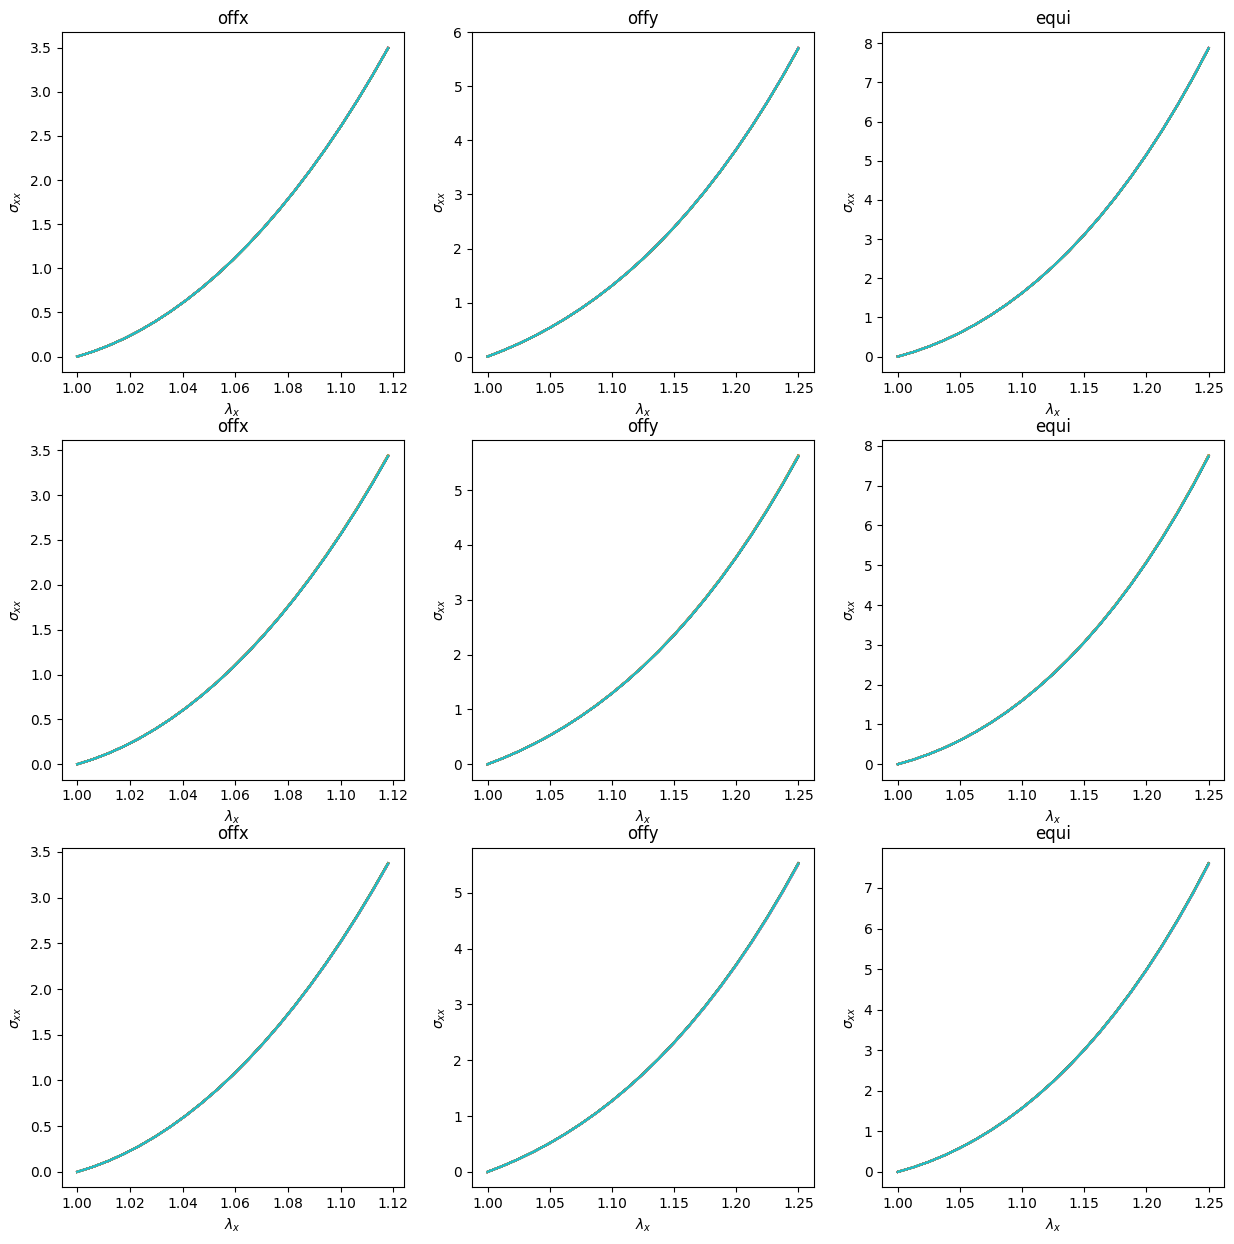

In [11]:
path = 'fem/square/'
fig, axes = plt.subplots(3,3,figsize=(15,15))
for sgmmsr, ax, panel in zip([0.04, 0.06, 0.08], axes, ['c', 'f', 'i']):
    for loading, axi in zip(['offx', 'offy', 'equi'], ax):
        fname = 'square_' + loading
        file = path + fname + '_sgmmsr_{}_lenscale_10.0_init_1.txt'.format(sgmmsr)
        data = np.loadtxt(file, skiprows=1)
        data_i = [data[:,0]]
        header = 'x'
        j = 1
        axi.set(title=loading, xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$')
        for lenscale in [10.0, 20.0, 30.0]:
            for init in range(1,11):
                file = path + fname + '_sgmmsr_{}_lenscale_{}_init_{}.txt'.format(sgmmsr, lenscale, int(init))
                data = np.loadtxt(file, skiprows=1)
                axi.plot(data[:,0], data[:,2]*1000)
                data_i.append(data[:,2]*1000)
                header+= ' y'+str(j)
                j+=1
        np.savetxt('tikz/fig_fem_dist_data/{}_{}.csv'.format(panel, loading), np.array(data_i).T, header=header, comments="")